# Data 512A : Human-centered data science

## A5: Final project - Russian ads

Date: 11/20/2019  
Author: Benjamin Brodeur Mathieu

## Q1 - Were some targeted demographics more engaged with the IRA ads?

We first import the packages required and load our "clean_data" dataframe which contains the fields detailed below.

| Field name             | Type     | Description                         |
|------------------------|----------|-------------------------------------|
| ad_targeting_interests | string   | Interests used to target users      |
| ad_impressions         | int      | Number of users who saw the ads     |
| ad_clicks              | int      | Number of times the ads was clicked |
| ad_spend               | float    | Money spent on the ad in RUB        |
| ad_creation_date       | datetime | Creation date of the ad             |
| ad_end_date            | datetime | Date at which the ad stopped        |

## Adding emographics

Picking demographics that the IRA attempted to target with their ads is a very subjective process. For this analysis, I've decided to use the following criterion to tie ads to a demographic:

### Criterion

* Similar words are used
* Similar social and or cutlural interests are shared

Demographics are not limited by race or ideologies, groups belonging to one demographic could very easily belong to a second demographic. Nothing forbids overlap between categories such as "Enjoy memes", "LGBT" or "Mexican-American". 

### Process

1. Create the list of interests as arrays of interest strings.
2. List the top X most frequent interests.
3. Attempt to create a demographic group with the top X interests.
4. Label rows based on the demographic group
5. Analyse whether terms related to those used to labelled the group should also be used as part of the interests labelling. If so add these to the labelling for the group and repeat 4-5, otherwise go to 2.
6. Stop listing interests frequency past 10 ads.


We stop past 10 ads as we want to identify demographics, being too specific makes it likely that we will instead be identifying ad campaigns.

In [1]:
import pandas as pd
import numpy as np
import re

ads_df = pd.read_csv('../clean_data/clean_data.csv', parse_dates=['ad_creation_date', 'ad_end_date'])
ads_df.head(3)

,file_name,ad_targeting_interests,ad_impressions,ad_clicks,ad_spend,ad_creation_date,ad_end_date
0,P(1)0002823.txt,"Pan-Africanism, African-American Civil Rights...",10496,1823,200.00,2017-04-21,2017-04-22
1,P(1)0002837.txt,"Pan-Africanism, African-American Civil Rights...",16305,1337,499.49,2017-04-13,2017-04-14
2,P(1)0006304.txt,"Martin Luther King, Jr., Stop Racism!!, Afric...",8210,1788,1570.03,2017-05-29,2017-05-29


In [2]:
comma_separation = re.compile(r'(?u)(?:^|,)([^\",\n]*)')
def get_arr_of_interests(interest_string):
    arr = []
    for g in re.finditer(comma_separation, interest_string):
        match_value = g.group(1).strip()
        if match_value and ' or ' in match_value:
            arr.extend(match_value.split(' or '))
        elif match_value:
            arr.append(match_value)
            
    if len(arr) == 0:
        arr.push(interest_string)
        
    return arr

In [3]:
ads_df['ad_interests_array'] = ads_df.ad_targeting_interests.apply(get_arr_of_interests)
ads_df['demographic'] = np.nan
ads_df.head(3)

,file_name,ad_targeting_interests,ad_impressions,ad_clicks,ad_spend,ad_creation_date,ad_end_date,ad_interests_array,demographic
0,P(1)0002823.txt,"Pan-Africanism, African-American Civil Rights...",10496,1823,200.00,2017-04-21,2017-04-22,"[Pan-Africanism, African-American Civil Rights...",NaN
1,P(1)0002837.txt,"Pan-Africanism, African-American Civil Rights...",16305,1337,499.49,2017-04-13,2017-04-14,"[Pan-Africanism, African-American Civil Rights...",NaN
2,P(1)0006304.txt,"Martin Luther King, Jr., Stop Racism!!, Afric...",8210,1788,1570.03,2017-05-29,2017-05-29,"[Martin Luther King, Jr., Stop Racism!!, Afric...",NaN


In [4]:
from collections import defaultdict

def print_top_words_from_arrays(series, n):
    word_dict = defaultdict(int)
    for arr in series:
        for val in arr:
            word_dict[val] += 1

    count = 0
    for w in sorted(word_dict, key=word_dict.get, reverse=True):
        print(w, word_dict[w])
        count +=1

        if count == n:
            break;

In [5]:
print_top_words_from_arrays(ads_df.ad_interests_array, 25)

African-American history 673
Malcolm X 601
Martin Luther King 590
Jr. 508
African-American Civil Rights Movement (1954-68) 455
Black (Color) 398
African-American culture 252
Pan-Africanism 242
La Raza 185
Chicano rap 183
Lowrider 175
Black Consciousness Movement 148
Black Matters 132
Stop Police Brutality 129
Black nationalism 118
Police misconduct 113
African-American Civil Rights Movement(1954-68) 107
HuffPost Black Voices 101
BlackNews.com 99
BuzzFeed 98
CollegeHumor 91
Mexico 88
. Hispanidad 88
9GAG 86
Latin hip hop 83


From this list of words, many seem to target African-American themes lets make this a first grouping using an apply function.

In [6]:
african_american_themes = {
    'African-American history',
    'Malcolm X',
    'Martin Luther King',
    'African-American Civil Rights Movement (1954-68)',
    'Black (Color)',
    'African-American culture',
    'Pan-Africanism',
    'Black Consciousness Movement',
    'Black Matters',
    'Black nationalism',
    'African-American Civil Rights Movement(1954-68)',
    'HuffPost Black Voices',
    'BlackNews.com'
}

def label_demographic(row, themes, group):
    interests_array = row['ad_interests_array']
    if pd.isnull(row['demographic']):
        for theme in themes:
            if theme in interests_array:
                    row['demographic'] = group
                    break
    return row


def label_demographic_rows(df, themes, group_name):
    df = df.apply(label_demographic, args=(themes, group_name), axis=1)
    print('This labelled %d rows!'% (df['demographic'] == group_name).sum())
    return df

In [7]:
ads_df = label_demographic_rows(ads_df, african_american_themes, 'African-American')

This labelled 1139 rows!


We now look at the frequency of interests referenced by these rows.

In [8]:
def print_top_references_for_theme(df, themes, group):
    rows = df[df['demographic'] == group]
    ad_interest_arrays = rows.ad_interests_array.apply(lambda x: list(set(x) - themes))
    print_top_words_from_arrays(ad_interest_arrays, 25)

In [9]:
print_top_references_for_theme(ads_df, african_american_themes, 'African-American')

Jr. 508
Stop Police Brutality 127
Police misconduct 113
Black history 74
Martin Luther King Ill 73
African-American Civil Rights Movement ( 1954-68) 63
AfricanAmerican culture 60
AfricanAmerican history 58
Jr.; African-American Civil Rights Movement (1954-68) 55
Black Power 43
Black History Month 43
Black Panther Party 41
Martin Luther King III 40
Black is beautiful 34
Say To No Racism 31
Angela Davis 31
Stop Racism!! 27
African American 27
African-American Civil Rights Movement (1954--68) 26
AfricanAmerican Civil Rights Movement(1954-68) 25
Black Girls Rock! 25
My Black is Beautiful 23
Anti-discrimination 23
African-American Civil Rights Movement (1954-68). African-American history 22
Human rights 19


In [10]:
african_american_themes = african_american_themes | {
    'Jr.',
    'Stop Police Brutality',
    'Police misconduct',
    'Black history',
    'Martin Luther King Ill',
    'African-American Civil Rights Movement ( 1954-68)',
    'AfricanAmerican culture',
    'AfricanAmerican history',
    'Jr.; African-American Civil Rights Movement (1954-68)',
    'Black Power',
    'Black History Month',
    'Black Panther Party',
    'Martin Luther King III',
    'Black is beautiful',
    'Say To No Racism',
    'Angela Davis',
    'Stop Racism!!',
    'African American',
    'African-American Civil Rights Movement (1954--68)',
    'AfricanAmerican Civil Rights Movement(1954-68)',
    'Black Girls Rock!',
    'My Black is Beautiful',
    'Anti-discrimination',
    'African-American Civil Rights Movement (1954-68). African-American history',
    'Human rights'
}

ads_df = label_demographic_rows(ads_df, african_american_themes, 'African-American')

This labelled 1196 rows!


In [11]:
print_top_references_for_theme(ads_df, african_american_themes, 'African-American')

Cop Block 23
Social justice 19
Gun Owners of America 18
2nd Amendment 18
Self Defense Family 18
The Self Defense Company 18
Martial arts 18
Racism in the United States 14
Martin Luther King; Jr. 14
Concealed carry in the United States 14
Huey P. Newton 14
Justice 13
Police brutality in the United States 12
Gun Rights 12
Police Brutality is a Crime 11
Nelson Mandela 10
Malcolm X Memorial Foundation 10
Black Enterprise 9
Jr.; African-American culture 9
African National Congress 9
HuffPost Politics 9
Black Business Works 9
Jr.; African-American Civil Rights Movement (1954-68). African-American history 8
Violence prevention 8
Pan Africanist Congress of Azania 8


In [12]:
african_american_themes = african_american_themes | {
    'Cop Block',
    'Social justice',
    'Racism in the United States',
    'Martin Luther King; Jr.',
    'Huey P. Newton',
    'Police brutality in the United States',
    'Police Brutality is a Crime',
    'Nelson Mandela',
    'Malcolm X Memorial Foundation',
    'Black Enterprise',
    'Jr.; African-American culture',
    'African National Congress',
    'HuffPost Politics',
    'Black Business Works',
    'Jr.; African-American Civil Rights Movement (1954-68). African-American history',
    'Pan Africanist Congress of Azania',
    'Violence prevention'
}

ads_df = label_demographic_rows(ads_df, african_american_themes, 'African-American')

This labelled 1245 rows!


In [13]:
print_top_references_for_theme(ads_df, african_american_themes, 'African-American')

Gun Owners of America 18
2nd Amendment 18
Self Defense Family 18
The Self Defense Company 18
Martial arts 18
Concealed carry in the United States 14
St. Louis 13
Justice 13
Gun Rights 12
Union of Huffington Post Writers and Bloggers 8
Baptism 8
Afrocentrism 7
Humanitarian aid 7
Humanitarianism 7
Fight the Power 7
2016 7
United States presidential election 7
Black Tea Patriots 7
Maya Angelou 7
Mumia AbuJamal 7
mother jones 7
National Museum of American History 7
The Raw Story 7
Gospel 7
Black Business Builders Club 7


In [14]:
african_american_themes = african_american_themes | {
    'St. Louis',
    'Union of Huffington Post Writers and Bloggers',
    'Baptism',
    'Afrocentrism',
    'Fight the Power',
    'United States presidential election',
    'Black Tea Patriots',
    'The Raw Story',
    'mother jones',
    'National Museum of American History',
    'Maya Angelou',
    'Mumia AbuJamal',
    'Gospel',
    'BLACK BUSINESS GLOBAL'
}

ads_df = label_demographic_rows(ads_df, african_american_themes, 'African-American')

This labelled 1276 rows!


In [15]:
print_top_references_for_theme(ads_df, african_american_themes, 'African-American')

Mumia Abu-Jamal 29
Gun Owners of America 18
2nd Amendment 18
Self Defense Family 18
The Self Defense Company 18
Martial arts 18
Concealed carry in the United States 14
Justice 13
Gun Rights 12
2016 9
Humanitarian aid 7
Humanitarianism 7
Black Business Builders Club 7
Kemetism 6
Medgar Evers 6
I Have a Dream 6
Mahatma Gandhi 6
African-American history. Malcolm X 6
Visual perception 6
Color 6
Baltimore 6
Freckle 6
Civil and political rights 6
AfricanAmerican culture. African-American Civil Rights Movement (1954-68) 5
Guns & Ammo 5


In [16]:
african_american_themes = african_american_themes | {
    'Mumia Abu-Jamal',
    'Black Business Builders Club',
    'Medgar Evers',
    'I Have a Dream',
    'African-American history. Malcolm X',
    'Baltimore',
    'Civil and political rights',
    'AfricanAmerican culture. African-American Civil Rights Movement (1954-68)',
}

ads_df = label_demographic_rows(ads_df, african_american_themes, 'African-American')

This labelled 1277 rows!


At this point the number of labelled rows no longer changes, we now identify the next demographic by only examining rows not previously labelled.

In [17]:
print_top_words_from_arrays(ads_df.ad_interests_array[pd.isnull(ads_df['demographic'])], 25)

La Raza 185
Chicano rap 183
Lowrider 175
BuzzFeed 98
CollegeHumor 91
Mexico 88
. Hispanidad 88
9GAG 86
Latin hip hop 83
Hispanidad 79
Mexico. Latin hip hop. Chicano Movement 79
Mexican Pride 73
Chicano Movement 73
Hispanic and latino american culture 70
Hispanic culture 70
Mexican american culture 68
Latino culture 66
LGBT United 64
Patriotism 56
Being Patriotic 55
Independence 53
Don't Shoot 47
Chicano 46
LGBT community 31
Donald Trump for President 24


Many of the terms are part of Mexican-American identity politics notably:

* [La Raza](https://en.wikipedia.org/wiki/La_Raza)
* [Chicano / Chicana](https://en.wikipedia.org/wiki/Chicano)
* [Lowrider](https://en.wikipedia.org/wiki/Lowrider)
* [Hispanidad](https://en.wikipedia.org/wiki/Hispanidad)

This will be the second manually-labelled group.

In [18]:
mexican_american_themes = {
    'La Raza',
    'Chicano rap',
    'Lowrider',
    'Mexico',
    '. Hispanidad',
    'Latin hip hop',
    'Hispanidad',
    'Maxico. Latin hip hop. Chicano Movement',
    'Mexican Pride',
    'Chicano Movement',
    'Hispanic and latino american culture',
    'Hispanic culture'
    'Mexican american culture',
    'Latino culture',
    'Chicano'
}

ads_df = label_demographic_rows(ads_df, mexican_american_themes, 'Mexican-American')

This labelled 189 rows!


In [19]:
print_top_references_for_theme(ads_df, mexican_american_themes, 'Mexican-American')

Mexico. Latin hip hop. Chicano Movement 79
Hispanic culture 70
Mexican american culture 68
Being Chicano 24
Chicano. Chicano Movement 23
Chicano Movement. Hispanidad 9
Mexico. Latin hip hop 9
Culture of Mexico 8
Being Chicano. Mexican american culture 4
Latin hip hop. Chicano 4
Being Mexican 4
Mexican American Pride 3
So Mexican 3
Lowrider; Chicano rap 2
Chicano Movement. Being Latino 2
Hispanic american culture 2
Latin hip hop. Chicano Movement 1
Mexican american culture; Hispanic american culture 1
Mexico; Latin hip hop. Chicano Movement. Hispanidad 1
Hispanic american culture. Chicano Movement 1
Being Latino 1


In [20]:
mexican_american_themes = mexican_american_themes | {
    'Mexico. Latin hip hop. Chicano Movement',
    'Hispanic culture',
    'Mexican american culture',
    'Being Chicano',
    'Chicano. Chicano Movement',
    'Chicano Movement. Hispanidad',
    'Mexico. Latin hip hop',
    'Culture of Mexico',
    'Being Chicano. Mexican american culture',
    'Latin hip hop. Chicano',
    'Being Mexican',
    'Mexican American Pride',
    'So Mexican',
    'Lowrider; Chicano rap',
    'Chicano Movement. Being Latino',
    'Hispanic american culture',
    'Latin hip hop. Chicano Movement',
    'Mexican american culture; Hispanic american culture',
    'Mexico; Latin hip hop. Chicano Movement. Hispanidad',
    'Hispanic american culture. Chicano Movement',
    'Being Latino'
}

ads_df = label_demographic_rows(ads_df, mexican_american_themes, 'Mexican-American')

This labelled 189 rows!


At this point the number of labelled rows no longer changes, we now identify the next demographic by only examining rows not previously labelled.

In [21]:
print_top_words_from_arrays(ads_df.ad_interests_array[pd.isnull(ads_df['demographic'])], 25)

BuzzFeed 98
CollegeHumor 91
9GAG 86
LGBT United 64
Patriotism 56
Being Patriotic 55
Independence 53
Don't Shoot 47
LGBT community 31
Donald Trump for President 24
Gun Owners of America 21
Donald Trump 21
iFunny 21
Imgur 20
Homosexuality 19
Politics 19
Funny Pics 19
Muslim Brotherhood 18
Funny Photo's 18
Funny Pictures 18
LOL 18
Native American Indian Wisdom 18
Cherokee language 18
Cherokee Nation 18
Republican Party (United States) 17


The most popular three terms describe their own category, people whom enjoy memes.

In [22]:
memes_themes = {
    'BuzzFeed',
    'CollegeHumor',
    '9GAG',
    'iFunny',
    'Imgur',
    'Funny Pics',
    'Funny Photo\'s',
    'Funny Pictures',
    'LOL'
}
ads_df = label_demographic_rows(ads_df, memes_themes, 'Memes')

This labelled 132 rows!


In [23]:
print_top_references_for_theme(ads_df, memes_themes, 'Memes')

Meme 9
Internet meme 9
Reddit 8
Fail Blog 8
NBA Memes 7
Meme Center 7
lmgur 3
Hobbies and activities 3
Entertainment 3
Humour 2
Reddit; BuzzFeed 1
Meme Center; NBA Memes 1
Imgur; CollegeHumor 1
Politics and social issues 1
Government 1


In [24]:
memes_themes = memes_themes | {
    'Meme',
    'Internet meme',
    'Reddit',
    'Fail Blog',
    'NBA Memes',
    'Meme Center',
    'lmgur',
    'Humour',
    'Reddit; BuzzFeed',
    'Meme Center; NBA Memes',
    'Imgur; CollegeHumor',
    'Funny Pics'
}
ads_df = label_demographic_rows(ads_df, memes_themes, 'Memes')

This labelled 137 rows!


At this point, very few new rows has been labelled. We find the next category.

In [25]:
print_top_words_from_arrays(ads_df.ad_interests_array[pd.isnull(ads_df['demographic'])], 25)

LGBT United 64
Patriotism 56
Being Patriotic 55
Independence 53
Don't Shoot 47
LGBT community 31
Donald Trump for President 24
Gun Owners of America 21
Donald Trump 21
Homosexuality 19
Politics 19
Muslim Brotherhood 18
Native American Indian Wisdom 18
Cherokee language 18
Cherokee Nation 18
Republican Party (United States) 17
Mixed martial arts 17
Martial arts 17
The Women's Self Defense Institute 17
PERSONAL & HOME DEFENSE 17
Self-defense 17
Selfdefense (United States) 17
Personal Defense 17
Right of self-defense 17
Self Defense Family 17


In [26]:
lgbt_themes = {
    'LGBT United',
    'LGBT community',
    'Homosexuality'
}
ads_df = label_demographic_rows(ads_df, lgbt_themes, 'LGBT')

This labelled 96 rows!


In [27]:
print_top_references_for_theme(ads_df, lgbt_themes, 'LGBT')

Same-sex marriage 12
LGBT culture 7
Gay pride 5
Fitness and wellness 4
Love 4
Motherhood 4
Indiana 4
territory 4
Lesbian community 4
LGBT rights by country 4
Philosophy 3
Society 3
LGBT social movements 3
Politics and social issues 2
Yoga 2
Family 2
Photography 2
Bernie Sanders 1
Hillary Clinton 1
LGBT Equality 1
Same-sex marriage in the United States 1
Rainbow flag (LGBT movement) 1
Gay Rights 1
Transgenderism 1
Human Sexuality 1


In [28]:
lgbt_themes = lgbt_themes  | {
    'Same-sex marriage',
    'LGBT culture',
    'Gay pride',
    'Love',
    'LGBT rights by country',
    'Lesbian community',
    'LGBT social movements',
    'Politics and social issues',
    'Yoga',
    'Gay Rights',
    'Human Sexuality',
    'Bisexuality'
}
ads_df = label_demographic_rows(ads_df, lgbt_themes, 'LGBT')

This labelled 97 rows!


At this point, very few new row have been labelled. We find the next category.

In [29]:
print_top_words_from_arrays(ads_df.ad_interests_array[pd.isnull(ads_df['demographic'])], 15)

Patriotism 56
Being Patriotic 55
Independence 53
Don't Shoot 47
Donald Trump for President 24
Gun Owners of America 21
Donald Trump 21
Politics 19
Muslim Brotherhood 18
Native American Indian Wisdom 18
Cherokee language 18
Cherokee Nation 18
Republican Party (United States) 17
Mixed martial arts 17
Martial arts 17


In [32]:
right_wing_themes = {
    'Patriotism',
    'Being Patriotic',
    'Independence',
    'Donald Trump for President',
    'Gun Owners of America',
    'Donald Trump',
    'Republican Party (United States)'
}
ads_df = label_demographic_rows(ads_df, right_wing_themes, 'Right wing')

This labelled 170 rows!


In [34]:
print_top_references_for_theme(ads_df, right_wing_themes, 'Right wing')

Donald Trump Jr. 13
Concealed carry in the United States 9
National Rifle Association 7
The Tea Party 7
Gun Rights 7
Politics 7
Syria 7
Right to keep and bear arms 6
National Association for Gun Rights 6
Conservatism 6
The Second Amendment 6
2nd Amendment 5
Guns & Ammo 4
Young Republicans 3
Second Amendment to the United States Constitution 3
Confederate States of America 3
Dixie 3
conservative daily 2
dead hands 2
From my cold 2
lvanka Trump Fine Jewelry 2
donald j trump 2
Gun Rights Across America 2
Second Amendment Sisters 2
Veterans Day 2


In [35]:
right_wing_themes = right_wing_themes | {
    'Donald Trump Jr.',
    'Concealed carry in the United States',
    'National Rifle Association',
    'The Tea Party',
    'Gun Rights',
    'Right to keep and bear arms',
    'National Association for Gun Rights',
    'Conservatism',
    'The Second Amendment',
    '2nd Amendment',
    'Guns & Ammo',
    'Young Republicans',
    'Second Amendment to the United States Constitution',
    'Confederate States of America',
    'Dixie',
    'conservative daily',
    'dead hands',
    'From my cold',
    'lvanka Trump Fine Jewelry',
    'donald j trump',
    'Gun Rights Across America',
    'Second Amendment Sisters',
    'Veterans Day'
}
ads_df = label_demographic_rows(ads_df, right_wing_themes, 'Right wing')

This labelled 200 rows!


In [36]:
print_top_references_for_theme(ads_df, right_wing_themes, 'Right wing')

Flags of the Confederate States of America 7
Politics 7
Syria 7
Guns & Patriots 4
Immigration 4
Hart of Dixie 4
Tea Party Patriots 4
Anything About Guns 3
American Guns 3
Guns.com 3
Second Amendment Supporters 3
Proud to be an American 3
Redneck Nation 3
Mud & Trucks 3
Conservative Tribune 3
100 Percent FED Up 3
Chicks On The Right 3
Sons of Confederate Veterans 2
Southern United States 2
Support Our Veterans 2
Students for Concealed Carry 2
Protect the Second Amendment 2
AR-15 2
ForAmerica 2
Confederate Flag 1


In [37]:
right_wing_themes = right_wing_themes | {
    'Flags of the Confederate States of America',
    'Guns & Patriots',
    'Immigration',
    'Hart of Dixie',
    'Tea Party Patriots',
    'Anything About Guns',
    'American Guns',
    'Guns.com',
    'Second Amendment Supporters',
    'Proud to be an American',
    'Redneck Nation',
    'Mud & Trucks',
    'Conservative Tribune',
    '100 Percent FED Up',
    'Chicks On The Right',
    'Sons of Confederate Veterans',
    'Southern United States',
    'Support Our Veterans',
    'Students for Concealed Carry',
    'Protect the Second Amendment',
    'AR-15',
    'ForAmerica',
    'Confederate Flag',
}
ads_df = label_demographic_rows(ads_df, right_wing_themes, 'Right wing')

This labelled 225 rows!


In [38]:
print_top_references_for_theme(ads_df, right_wing_themes, 'Right wing')

Politics 16
Syria 7
Confederate States Army 4
Support our troops 4
Supporting Our Veterans 3
Southern Pride 3
The Invaders 3
Veterans For America 3
Iraq and Afghanistan Veterans of America 3
Vietnam Veterans of America Foundation 3
Vietnam Veterans of America 3
American patriotism 2
Flag of the United States 2
American Patriots 2
American Patriot 2
Human migration 2
Illegal immigration 2
Disabled American Veterans 2
US Military Veterans 2
Concerned Veterans for America 2
Patriot Nation 2
confederate states america 1
Robert E. Lee 1
Redneck Social Club 1
United Daughters of the Confederacy 1


In [39]:
right_wing_themes = right_wing_themes | {
    'Confederate States Army',
    'Support our troops',
    'Supporting Our Veterans',
    'Southern Pride',
    'The Invaders',
    'Veterans For America',
    'Iraq and Afghanistan Veterans of America',
    'Vietnam Veterans of America Foundation',
    'Vietnam Veterans of America',
    'American patriotism',
    'Flag of the United States',
    'American Patriots',
    'American Patriot',
    'Human migration',
    'Illegal immigration',
    'Disabled American Veterans',
    'US Military Veterans',
    'Concerned Veterans for America',
    'Patriot Nation',
    'confederate states america',
    'Robert E. Lee',
    'Redneck Social Club',
    'United Daughters of the Confederacy'
}
ads_df = label_demographic_rows(ads_df, right_wing_themes, 'Right wing')

This labelled 238 rows!


In [40]:
print_top_references_for_theme(ads_df, right_wing_themes, 'Right wing')

Politics 16
Veterans 8
Syria 7
United States Department of Veterans Affairs 6
Vietnam Veterans Memorial Fund 3
Stop Illegal Immigration 3
vietnam veterans america 2
Vietnam Veterans Against the War 2
Institute for Veterans and Military Families 2
Vietnam Veterans Memorial 2
Chris Kyle 2
Wounded Warrior Project 2
Deportation 2
Immigration law 2
Fox News Politics 1
American History 1
Patriot(American Revolution) 1
Conservative News Today 1
The Conservative 1
College Republicans 1
Conservatism in the United States 1
Concealed carry 1
Tea Party movement 1
Ted Cruz 1
Conservative Republicans of Texas 1


In [41]:
right_wing_themes = right_wing_themes | {
    'Veterans',
    'United States Department of Veterans Affairs',
    'Vietnam Veterans Memorial Fund',
    'Stop Illegal Immigration',
    'vietnam veterans america',
    'Vietnam Veterans Against the War',
    'Institute for Veterans and Military Families',
    'Vietnam Veterans Memorial',
    'Chris Kyle',
    'Wounded Warrior Project',
    'Deportation',
    'Immigration law',
    'Fox News Politics',
    'American History',
    'Patriot(American Revolution)',
    'Conservative News Today',
    'The Conservative',
    'College Republicans',
    'Conservatism in the United States',
    'Concealed carry',
    'Tea Party movement',
    'Ted Cruz',
    'Conservative Republicans of Texas'
}
ads_df = label_demographic_rows(ads_df, right_wing_themes, 'Right wing')

This labelled 247 rows!


In [42]:
print_top_references_for_theme(ads_df, right_wing_themes, 'Right wing')

Politics 17
Syria 7
Fox News Channel 3
Military 2
Bill O'Reilly (political commentator) 2
Mike Pence 2
Jesus; TheBlaze 2
Christianity 2
Rand Paul 2
Tucker Carlson 2
Andrew Breitbart breitbart 2
Bible 2
Ron Paul 2
Michael Savage 2
Michelle Malkin 2
Rush Limbaugh 2
Mike Huckabee 2
Donald Trump Jr.; Politics US politics (very conservative) 2
Laura Ingraham 2
Conservatism in the United States; Sean Hannity 2
Thank A Soldier 1
U.S. Patriot Tactical 1
The Patriot Post 1
AMVETS 1
Emigration 1


In [43]:
right_wing_themes = right_wing_themes | {
    'Fox News Channel',
    'Military',
    'Bill O\'Reilly (political commentator)',
    'Mike Pence',
    'Jesus; TheBlaze',
    'Christianity',
    'Rand Paul',
    'Tucker Carlson',
    'Andrew Breitbart breitbart',
    'Bible',
    'Ron Paul',
    'Michael Savage',
    'Michelle Malkin',
    'Rush Limbaugh',
    'Mike Huckabee',
    'Donald Trump Jr.; Politics US politics (very conservative)',
    'Laura Ingraham',
    'Conservatism in the United States; Sean Hannity',
    'Thank A Soldier',
    'U.S. Patriot Tactical',
    'The Patriot Post',
    'AMVETS',
    'Emigration',
}
ads_df = label_demographic_rows(ads_df, right_wing_themes, 'Right wing')

This labelled 248 rows!


Rows have stopped growing we move on to the next group.

In [45]:
print_top_words_from_arrays(ads_df.ad_interests_array[pd.isnull(ads_df['demographic'])], 15)

Don't Shoot 47
Muslim Brotherhood 18
Native American Indian Wisdom 18
Cherokee language 18
Cherokee Nation 18
Mixed martial arts 17
Martial arts 17
The Women's Self Defense Institute 17
PERSONAL & HOME DEFENSE 17
Self-defense 17
Selfdefense (United States) 17
Personal Defense 17
Right of self-defense 17
Self Defense Family 17
Active Self Protection 17


An web search revealed that 'Don't Shoot' was a group constructed by the IRA after the [shooting of Philando Castille](https://en.wikipedia.org/wiki/Internet_Research_Agency). This was most-likely targeting African-Americans. We add it ot this category before proceeding.

In [47]:
african_american_themes = african_american_themes | {
    'Don\'t Shoot'
}

ads_df = label_demographic_rows(ads_df, african_american_themes, 'African-American')

This labelled 1324 rows!


In [48]:
print_top_references_for_theme(ads_df, african_american_themes, 'African-American')

Gun Owners of America 18
2nd Amendment 18
Self Defense Family 18
The Self Defense Company 18
Martial arts 18
Concealed carry in the United States 14
Justice 13
Gun Rights 12
2016 9
Humanitarian aid 7
Humanitarianism 7
Kemetism 6
Mahatma Gandhi 6
Visual perception 6
Color 6
Freckle 6
Guns & Ammo 5
Jr.. Stop Racism!!. AfricanAmerican culture. African-American Civil Rights Movement (1954-68) 5
Black history. AfricanAmerican Civil Rights Movement(1954-68) 5
Filming Cops 5
Melanin 5
Black panther 5
Slavery in the United States 5
Equal opportunity 5
Culture 5


In [49]:
african_american_themes = african_american_themes | {
    'Jr.. Stop Racism!!. AfricanAmerican culture. African-American Civil Rights Movement (1954-68)',
    'Black history. AfricanAmerican Civil Rights Movement(1954-68)',
    'Filming Cops',
    'Melanin',
    'Black panther',
    'Slavery in the United States'
}

ads_df = label_demographic_rows(ads_df, african_american_themes, 'African-American')

This labelled 1325 rows!


The number of rows has stabilized, we move on to the next group.

In [50]:
print_top_words_from_arrays(ads_df.ad_interests_array[pd.isnull(ads_df['demographic'])], 15)

Muslim Brotherhood 18
Native American Indian Wisdom 18
Cherokee language 18
Cherokee Nation 18
Mixed martial arts 17
Martial arts 17
The Women's Self Defense Institute 17
PERSONAL & HOME DEFENSE 17
Self-defense 17
Selfdefense (United States) 17
Personal Defense 17
Right of self-defense 17
Self Defense Family 17
Active Self Protection 17
American Indian Movement 17


Out of the top values of 18 rows, many have to do with Native-American hence our new category.

In [51]:
native_american_themes = {
    'Native American Indian Wisdom',
    'Cherokee language',
    'Cherokee Nation',
    'American Indian Movement'
}
ads_df = label_demographic_rows(ads_df, native_american_themes, 'Native-American')

This labelled 18 rows!


In [52]:
print_top_references_for_theme(ads_df, native_american_themes, 'Native-American')

Native News Online 4
Indian Country Today Media Network 3
Native American civil rights 2
American Indian Wars 1
Cherokee 1
All Things Cherokee 1
Native american culture in the united states 1
National Congress of American Indians 1
Native American Times 1
Native American music 1


In [53]:
native_american_themes = native_american_themes | {
    'Native News Online',
    'Indian Country Today Media Network',
    'Native American civil rights',
    'All Things Cherokee',
    'Cherokee',
    'American Indian Wars',
    'Native american culture in the united states',
    'National Congress of American Indians',
    'Native American Times',
    'Native American music'
}
ads_df = label_demographic_rows(ads_df, native_american_themes, 'Native-American')

This labelled 18 rows!


No new rows were added we move to the next category.

In [54]:
print_top_words_from_arrays(ads_df.ad_interests_array[pd.isnull(ads_df['demographic'])], 15)

Muslim Brotherhood 18
Mixed martial arts 17
Martial arts 17
The Women's Self Defense Institute 17
PERSONAL & HOME DEFENSE 17
Self-defense 17
Selfdefense (United States) 17
Personal Defense 17
Right of self-defense 17
Self Defense Family 17
Active Self Protection 17
Libertarianism 13
Liberalism 13
Williams&Kalvin 13
Islam 12


In [55]:
muslim_american_themes = {
    'Muslim-Brotherhood',
    'Islam'
}

ads_df = label_demographic_rows(ads_df, muslim_american_themes, 'Muslim-American')

This labelled 12 rows!


In [56]:
print_top_references_for_theme(ads_df, muslim_american_themes, 'Muslim-American')

Quran 6
Allah 6
Muslim Brotherhood 5
Islamism 4
Muhammad 4
Islam in the United States 3
Muslim world 3
All-american muslim culture 3
Muslim American Society 2
State of Palestine 2
Mosque 2
Sunnah 2
Glossary of Islam 2
Sharia 2
Current events 1
Muslim Students' Association 1
Religion 1
Al Jazeera 1
ProductiveMuslim 1
Muslims Are Not Terrorists 1
Muhammad al-Baqir 1
Hajj 1
Hasan ibn Ali 1
Assalamu alaykum 1
Ahl al-Bayt 1


In [57]:
muslim_american_themes = muslim_american_themes | {
    'Quran',
    'Allah',
    'Muslim Brotherhood',
    'Islamism',
    'Muhammad',
    'Islam in the United States',
    'Muslim world',
    'All-american muslim culture',
    'Muslim American Society',
    'State of Palestine',
    'Mosque',
    'Sunnah',
    'Glossary of Islam',
    'Sharia',
    'Muslim Students\' Association',
    'Religion',
    'Al Jazeera',
    'ProductiveMuslim',
    'Muslims Are Not Terrorists',
    'Muhammad al-Baqir',
    'Hajj',
    'Hasan ibn Ali',
    'Assalamu alaykum',
    'Ahl al-Bayt'
}
ads_df = label_demographic_rows(ads_df, muslim_american_themes, 'Muslim-American')

This labelled 30 rows!


In [58]:
print_top_references_for_theme(ads_df, muslim_american_themes, 'Muslim-American')

Hijra (Islam) 3
Mecca 2
Prophets and messengers in Islam 2
As-salamu alaykum 2
Proud to be A Muslim 2
Abu Eesa Niamatullah 1
Zaid Shakir 1
State of Palestine; Muslim world; Mosque 1
Islam ; Quran 1
Current events 1
Haram 1
Hadith 1
Muslim Youth 1
Zakat 1
Medina 1
Muslim League (Pakistan) 1
Imam Ali Mosque 1
History of Islam 1
All Pakistan Muslim League 1
Islam Book 1
Ana muslim 1
Fiqh 1
Ja'far al-Sadiq 1
Muslims Are Not Terrorists. Islamism 1
Arab world 1


In [59]:
muslim_american_themes = muslim_american_themes | {
    'Hijra (Islam)',
    'Mecca',
    'Prophets and messengers in Islam',
    'As-salamu alaykum',
    'Proud to be A Muslim',
    'Abu Eesa Niamatullah',
    'Zaid Shakir',
    'State of Palestine; Muslim world; Mosque',
    'Islam ; Quran',
    'Haram',
    'Hadith',
    'Muslim Youth',
    'Zakat',
    'Medina',
    'Muslim League (Pakistan)',
    'Imam Ali Mosque',
    'History of Islam',
    'All Pakistan Muslim League',
    'Islam Book',
    'Ana muslim',
    'Fiqh',
    'Ja\'far al-Sadiq',
    'Muslims Are Not Terrorists. Islamism',
    'Arab world'
}
ads_df = label_demographic_rows(ads_df, muslim_american_themes, 'Muslim-American')

This labelled 40 rows!


In [60]:
print_top_references_for_theme(ads_df, muslim_american_themes, 'Muslim-American')

Muslims for America 10
Current events 1
Prod uctiveMuslim 1
Hillary Clinton 1
Islam ism 1
Ramadan 1
Allah Akbr 1


In [61]:
muslim_american_themes = muslim_american_themes | {
    'Muslims for America',
    'Current events',
    'Prod uctiveMuslim',
    'Hillary Clinton',
    'Islam ism',
    'Ramadan',
    'Allah Akbr'
}
ads_df = label_demographic_rows(ads_df, muslim_american_themes, 'Muslim-American')

This labelled 40 rows!


The number of rows has stabilized we move on to the next group.

In [62]:
print_top_words_from_arrays(ads_df.ad_interests_array[pd.isnull(ads_df['demographic'])], 15)

Mixed martial arts 17
Martial arts 17
The Women's Self Defense Institute 17
PERSONAL & HOME DEFENSE 17
Self-defense 17
Selfdefense (United States) 17
Personal Defense 17
Right of self-defense 17
Self Defense Family 17
Active Self Protection 17
Libertarianism 13
Liberalism 13
Williams&Kalvin 13
Free software 10
Stop A.1. 10


In [63]:
self_defense = {
    'Mixed martial arts',
    'Martial arts',
    'The Women\'s Self Defense Institute',
    'PERSONAL & HOME DEFENSE',
    'Self-defense',
    'Selfdefense (United States)',
    'Personal Defense',
    'Right of self-defense',
    'Self Defense Family',
    'Active Self Protection'
}
ads_df = label_demographic_rows(ads_df, self_defense, 'Self-Defense')

This labelled 17 rows!


In [64]:
print_top_references_for_theme(ads_df, self_defense, 'Self-Defense')

In [65]:
print_top_words_from_arrays(ads_df.ad_interests_array[pd.isnull(ads_df['demographic'])], 15)

Libertarianism 13
Liberalism 13
Williams&Kalvin 13
Free software 10
Stop A.1. 10
United Muslims of America 9
Antelope Valley College 9
Bernie Sanders 8
Police 8
Blacktivist 6
Police officer 6
Jesus Daily 6
Texas 6
free music 5
Law enforcement 5


There is no clear association to be made, we go back to the top list

In [67]:
print_top_words_from_arrays(ads_df.ad_interests_array[pd.isnull(ads_df['demographic'])], 15)

Libertarianism 13
Liberalism 13
Williams&Kalvin 13
Free software 10
Stop A.1. 10
United Muslims of America 9
Antelope Valley College 9
Bernie Sanders 8
Police 8
Blacktivist 6
Police officer 6
Jesus Daily 6
Texas 6
free music 5
Law enforcement 5


Libertarianism seems to belong in the right-wing category, while United Muslims of America should be put in Muslim Americain.

In [68]:
muslim_american_themes = muslim_american_themes | {
    'United Muslims of America'
}
ads_df = label_demographic_rows(ads_df, muslim_american_themes, 'Muslim-American')

This labelled 49 rows!


In [69]:
print_top_references_for_theme(ads_df, muslim_american_themes, 'Muslim-American')

In [77]:
right_wing_themes = right_wing_themes | {
    'Libertarianism',
    'Williams&Kalvin'
}
ads_df = label_demographic_rows(ads_df, right_wing_themes, 'Right wing')

This labelled 274 rows!


In [79]:
print('At this point, only ' + str(pd.isnull(ads_df['demographic']).sum()) + ' ads are unlabelled.')

At this point, only 120 ads are unlabelled.


In [76]:
for v in ads_df[pd.isnull(ads_df['demographic'])]['ad_targeting_interests']:
    print(v)

Free software 
Free software 
Bernie Sanders
 free music or Free software
Reading
Blacktivist
 Grooveshark, Last.fm, SoundCloud, Vevo, Shazam (service) or Google Play Music
 Bernie Sanders, Social democracy, Liberalism or Democratic Party (United States)
Right-wing politics 
Blacktivist
 Antelope Valley College, 
 Free software 
 Antelope Valley College, 
Stop A.1.
Blacktivist
 Black Economic Empowerment 
Copwatch Rodney King; Police brutality in the United States; Stop Police Brutality; Cop Block or Photography is Not a Crime
Born Liberal
 Bernie Sanders or Liberalism
 Security alarm, Police, National security, Security guard, Police officer or Safety
Detroit
History 
Stop A.1.
Police, Law enforcement or Police officer
Stop A.1.
 Music or Rock music 
Iraq War Veterans, Veterans of Foreign Wars, Support Our Veterans. Veterans benefits support; Disabled American Veterans, Veterans Advantage or Dysfunctional Veterans
 State police, Law enforcement in the United States, Police, Sheriffs i

In [80]:
ads_df['demographic'].value_counts()

African-American    1325
Right wing           274
Mexican-American     189
Memes                137
LGBT                  97
Muslim-American       49
Native-American       18
Self-Defense          17
Name: demographic, dtype: int64

We will be using scikit learn to extract features using a technique called tfidf. (Term Frequency - Inverse Document Frequency) As per it's [wikipedia entry](https://en.wikipedia.org/wiki/Tf%E2%80%93idf):

>The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.

The Tfid method requires our data to be vectorized by creating a feature vector of length vocabulary determined by the number of distinct words found in all rows of the ad_targeting_interests column. In the interest of time, we will be using scikit's TfidVectorizer with the stop_words option so that punctuation and words such as 'and' and 'or' get pruned automatically. This approach is not perfect as it also removes hyphens which are used fairly frequently to join words in this dataset.

In [317]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [423]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=8000)
vectorizer.fit(rest.ad_targeting_interests)
text = vectorizer.transform(rest.ad_targeting_interests)

In [424]:
text

<826x605 sparse matrix of type '<class 'numpy.float64'>'
	with 4987 stored elements in Compressed Sparse Row format>

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 22 clusters
Fit 24 clusters
Fit 26 clusters
Fit 28 clusters
Fit 30 clusters


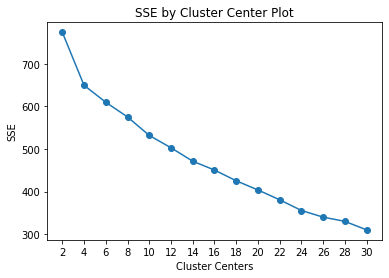

In [425]:
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(text, 30)

In [426]:
clusters = MiniBatchKMeans(n_clusters=20, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)

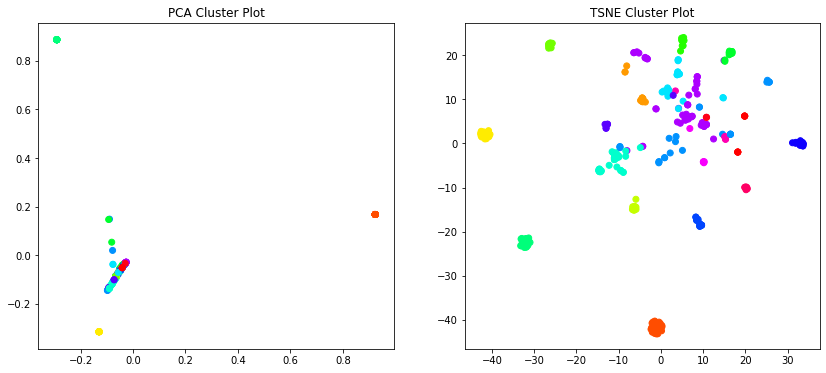

In [430]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=700, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=20).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(text, clusters)

In [429]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(text, clusters, vectorizer.get_feature_names(), 10)


Cluster 0
fly,fm,follow,foramerica,forces,flag,zion,williams,kalvin,stop

Cluster 1
fitness,flags,fly,fm,follow,foramerica,forces,flag,zion,patriotic

Cluster 2
abu,zaid,shakir,eesa,niamatullah,united,owners,gun,muslims,america

Cluster 3
fly,fm,follow,foramerica,forces,foreign,fox,zion,don,shoot

Cluster 4
foundation,social,band,justice,police,corruption,cops,filming,block,cop

Cluster 5
abu,mother,jones,museum,angelou,jamal,maya,story,mumia,raw

Cluster 6
daily,young,tea,party,conservative,republicans,jr,president,donald,trump

Cluster 7
department,affairs,american,military,vietnam,supporting,day,support,disabled,veterans

Cluster 8
fitness,flag,flags,fly,fm,follow,foramerica,forces,patriotism,independence

Cluster 9
king,luther,color,enterprise,rock,girls,panther,power,beautiful,black

Cluster 10
arts,tea,america,republican,party,united,self,confederate,defense,states

Cluster 11
rights,african,libertarianism,black,liberalism,cherokee,indian,movement,american,police

Cluster 12
cop

## Question 2 - Are targeted demographics who are shown more ads more likely to interact with them?

Now that our dataset has been labelled by demographic, we can plot the click through rate by demographics over time. We first sum the ad_clicks and ad_impressions by demographic. For each demographic we then calculate the click through rate by dividing clicks by impressions.

In [248]:
# generate random integer values
from random import seed
from random import randint

seed(1)
randints = [randint(0,4) for x in range(len(ads_df))]
ads_df_with_demographic = ads_df.assign(demographic=randints)

In [249]:
ads_df_with_demographic.head(2)

,file_name,ad_targeting_interests,ad_impressions,ad_clicks,ad_spend,ad_creation_date,ad_end_date,demographic
0,P(1)0002823.txt,"Pan-Africanism, African-American Civil Rights...",10496,1823,200.00,2017-04-21,2017-04-22,1
1,P(1)0002837.txt,"Pan-Africanism, African-American Civil Rights...",16305,1337,499.49,2017-04-13,2017-04-14,4


We remove columns we will not be using for the groupby and add a column set to 1 to make the column count easy to compute using "sum" as an aggregation function.

In [272]:
# Select only the columns we need
df = ads_df_with_demographic[['demographic', 'ad_clicks', 'ad_impressions']]

# Add column to do ad_count with "sum" aggregator
df = df.assign(ad_count=1)

# Aggregation
aggregated_demographic = df.groupby(['demographic']).sum()

# Caculate click through rate
aggregated_demographic['click_through_rate'] = aggregated_demographic.ad_clicks/aggregated_demographic.ad_impressions

In [273]:
aggregated_demographic

,ad_clicks,ad_impressions,ad_count,click_through_rate
demographic,,,,
0,854383,8575763,438,0.099628
1,594589,5500064,426,0.108106
2,702871,7845456,455,0.089590
3,648538,7143333,418,0.090789
4,780255,8783124,489,0.088836


## Question 3 - How did the amount of ads seen by targeted demographics change preceding political events?

The image below taken from a [report](https://comprop.oii.ox.ac.uk/wp-content/uploads/sites/93/2018/12/IRA-Report.pdf) made by an Oxford group shows that the number of ads on Facebook spiked before and sometimes shortly after important political events of the 2016 election.

![Oxford events important political events timeline](../assets/pictures/important_events.png)

12/18/2015 - [Third democratic debate](https://en.wikipedia.org/wiki/2016_Democratic_Party_presidential_debates_and_forums#Schedule)  
01/14/2016 - [Sixth republican debate](https://en.wikipedia.org/wiki/2016_Republican_Party_presidential_debates_and_forums)  
02/01/2016 - [Iowa caucuses (start of primaries)](https://en.wikipedia.org/wiki/2016_Democratic_Party_presidential_primaries)  
06/14/2016 - [End of primaries](https://en.wikipedia.org/wiki/2016_Democratic_Party_presidential_primaries)  
09/16/2016 - [First presidential debate between Hillary and Donald](https://en.wikipedia.org/wiki/2016_United_States_presidential_debates#First_presidential_debate)  
10/04/2016 - [Second presidential debate between Hillary and Donald](https://en.wikipedia.org/wiki/2016_United_States_presidential_debates#Second_presidential_debate)  
10/14/2016 - [Third presidential debate between Hillary and Donald](https://en.wikipedia.org/wiki/2016_United_States_presidential_debates#Third_presidential_debate)  
11/08/2016 - [Election day](https://en.wikipedia.org/wiki/2016_United_States_presidential_election)  
12/29/2016 - [Obama announces sanctions against Russia](https://en.wikipedia.org/wiki/Special_Counsel_investigation_(2017%E2%80%932019)#Links_between_Trump_associates_and_Russian_officials)

First we import a few libraries which will be useful:
    * datetime for calculating time intervals
    * matplotlib's pyplot for graphing

In [226]:
from datetime import timedelta
import math
import matplotlib.pyplot as plt

We then create a dictionary of important events and the timerange before and after the important date we will be examining. For each important events, we add the event_name entry which will be used whend displaying the results as well as a mask entry which will enable us to filter adds to the selected period.

In [172]:
political_events = {
    '12/18/2015': {'date_range': [], 'event_name': '3rd Dem. debate', 'mask': [] },
    '01/14/2016': {'date_range': [], 'event_name': '6th Rep. debate', 'mask': [] },
    '02/01/2016': {'date_range': [], 'event_name': 'Iowa caucuses', 'mask': [] },
    '06/14/2016': {'date_range': [], 'event_name': 'End of primary', 'mask': [] },
    '09/16/2016': {'date_range': [], 'event_name': '1st Pres. debate', 'mask': [] },
    '10/04/2016': {'date_range': [], 'event_name': '2nd Pres. debate', 'mask': [] },
    '10/14/2016': {'date_range': [], 'event_name': '3rd Pres. debate', 'mask': [] },
    '11/08/2016': {'date_range': [], 'event_name': 'Election', 'mask': [] },
    '12/29/2016': {'date_range': [], 'event_name': 'Sanctions on Russia', 'mask': [] }
}

Ads currently have an start and sometimes and end date. According to the "CITATION HERE" study, ads that only have a creation date are most likely to have run for that day only where ads that have both a start and end date have ran for mutliple days. To filter the ads to a given date range around the political event we first need to duplicate rows so that the number of ads shown by demographic by day can be counted correctly.

Below we create a function which duplicates rows that ran for multiple days.

In [206]:
# Given a dataframe with non-null start date string column and end date string column
# returns a new dataset with duplicate rows for all days between start and end date inclusive
def expand_dates(df, start, end, new_col_name):
    all_rows = []
    
    # For each row
    for index, row in df.iterrows():
        # Select start date
        start_timestamp = pd.to_datetime(row[start])
        
        # If end date is null put same as start
        if (pd.isnull(row[end])):
            end_timestamp = start_timestamp
        else:
            end_timestamp = pd.to_datetime(row[end])

        # For dates until active is bigger than end
        active_timestamp = start_timestamp
        while active_timestamp <= end_timestamp:
            new_row = row.append(pd.Series([active_timestamp], index=[new_col_name]))
            all_rows.append(new_row)
            active_timestamp += timedelta(days=1)
    
    return pd.DataFrame(all_rows)

In [207]:
ads_dates_expanded = expand_dates(ads_df, 'ad_creation_date', 'ad_end_date', 'active_date')
ads_dates_expanded.head(3)

,file_name,ad_targeting_interests,ad_impressions,ad_clicks,ad_spend,ad_creation_date,ad_end_date,active_date
0,P(1)0002823.txt,"Pan-Africanism, African-American Civil Rights...",10496,1823,200.00,2017-04-21,2017-04-22,2017-04-21
1,P(1)0002823.txt,"Pan-Africanism, African-American Civil Rights...",10496,1823,200.00,2017-04-21,2017-04-22,2017-04-22
2,P(1)0002837.txt,"Pan-Africanism, African-American Civil Rights...",16305,1337,499.49,2017-04-13,2017-04-14,2017-04-13


In [209]:
def get_date_range(middle_date_string, days):
    middle_date_timestamp = pd.to_datetime(middle_date_string)
    end_date = middle_date_timestamp + timedelta(days=days)
    start_date = middle_date_timestamp - timedelta(days=days)
    return start_date, end_date

days_range = 7
for date_string, _ in important_events.items():
    start_date, end_date = get_date_range(date_string, days_range)
    political_events[date_string]['mask'] = (ads_dates_expanded['active_date'] >= start_date) & (ads_dates_expanded['active_date'] <= end_date)

In [234]:
event_date_string = '10/14/2016'

In [235]:
rows = ads_dates_expanded[political_events[event_date_string]['mask']]

In [236]:
counts_df = rows['active_date'].value_counts()

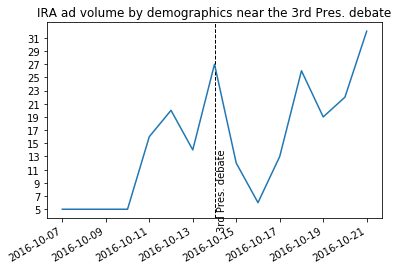

In [237]:
plt.title('IRA ad volume by demographics near the ' + political_events[event_date_string]['event_name'])
plt.axvline(pd.to_datetime(event_date_string), linestyle='--', linewidth=1, c='black')
plt.text(pd.to_datetime(event_date_string) + timedelta(minutes=180), 2, political_events[event_date_string]['event_name'], rotation=90)

plt.yticks(range(min(counts_df), math.ceil(max(counts_df))+1, 2))
plt.plot(counts_df.sort_index())
plt.gcf().autofmt_xdate()
plt.show()